In [1]:
import scanpy as scp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scrublet as scr
import seaborn as sb
import os

import sys
sys.path.append('../../')
from pipelines import *

from parameters import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
adata = scp.read("/lustre/projects/Stembryo_Seq/Meissner_gabriel/raw.h5ad") #loads post-convo r-object data

#Load to the working matrix the raw counts
adata.X = adata.obsm["Raw"].copy()

In [3]:
#addmetadata
meta = pd.read_csv('/lustre/projects/Stembryo_Seq/emb_meta_meissner2.csv')
adata.obs['BC']=meta['Unnamed: 0'].values
adata.obs['Stage']=meta['stage'].values
adata.obs['Cluster']=meta['cluster'].values
adata.obs['Sample']=meta['sample'].values
adata.obs.head()

BC  Stage  Cluster  Sample
0  WT65;SG4_AAACCTGAGGTGTGGT-1  WT_65     17.0      47
1  WT65;SG4_AAACCTGCACCAGGCT-1  WT_65     17.0      28
2  WT65;SG4_AAACCTGGTAAGGATT-1  WT_65      4.0       1
3  WT65;SG4_AAACCTGGTACAGACG-1  WT_65     17.0       1
4  WT65;SG4_AAACCTGGTGTTCGAT-1  WT_65      4.0      16

# Basic QC measures

The quality control is based on the following metrics:

1. Total count of reads per cell
2. Total count of non-zero genes per cell
3. Mitochondrial fraction

The dataset as already provided by the authors has removed the tails of the total counts. The only group of cells that have not been removed are stripped cells, as detected by the bimodality at very low mitochondrial fractions. We set a threshold for imputing these cells as stripped cells.

In [4]:
mtGenesPositions = np.array([i for i,j in enumerate(adata.var["Gene"]) if "mt-" in j])

In [5]:
quality_control_metrics(adata,mtGenesPositions)

## UMI counts per cell

The UMI counts does not have a cutoff. We keep the cutoff at 5000, as it seems to fall in the basin of the bimodality between the removed lower UMI count (<5000) and the proper count distribution.

We do not set any upper bound, in the same way of their analysis. If high count cells are doublets, very probably they will be detected in by the doublet deconvolution procedure we will perform afterwards.

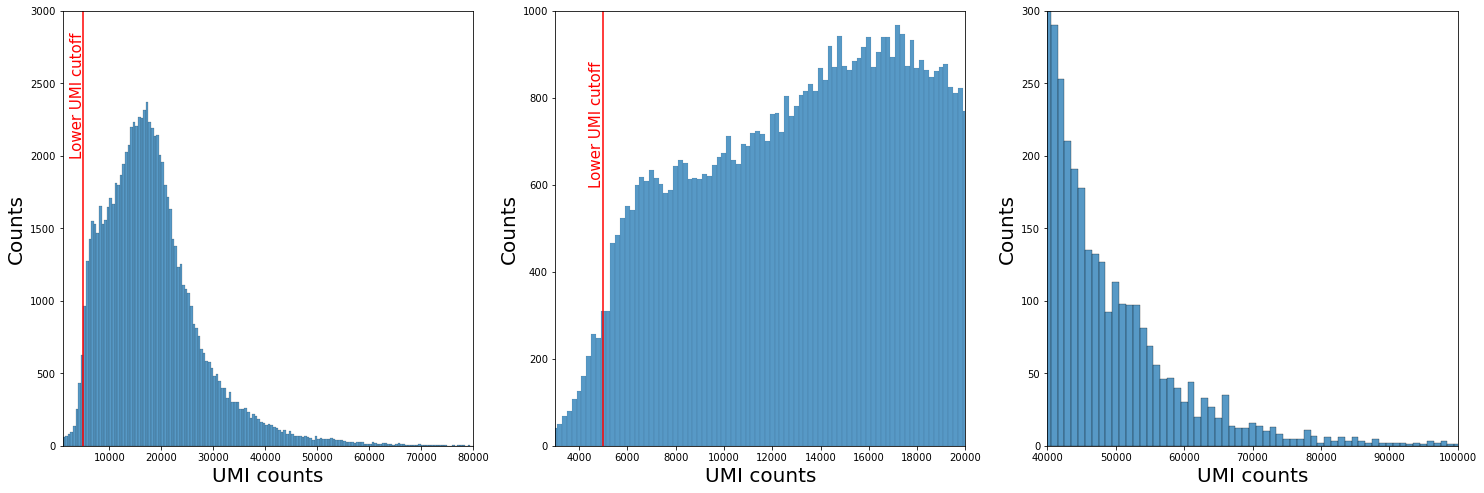

In [6]:
fig,ax = plt.subplots(1,3,figsize=[25,8])

##Counts
i0 = 0; i1 = None;
sb.histplot(data=adata.obs,x="#Counts",ax=ax[i0],binwidth=500);
ax[i0].axis([1000,80000,0,3000])
ax[i0].vlines(MIN_COUNTS,0,5000,color="r")
ax[i0].text(MIN_COUNTS-2600,2000,"Lower UMI cutoff",color="red",fontsize=15,rotation="vertical")
#ax[i0,i1].vlines(maxCounts,0,5000,color="r")
#ax[i0,i1].text(maxCounts+600,3500,"Upper UMI cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("UMI counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

i0 = 1; i1 = 1;
sb.histplot(data=adata.obs,x="#Counts",ax=ax[i0],binwidth=200);
ax[i0].axis([3000,20000,0,1000])
ax[i0].vlines(MIN_COUNTS,0,5000,color="r")
ax[i0].text(MIN_COUNTS-600,600,"Lower UMI cutoff",color="red",fontsize=15,rotation="vertical")
#ax[i0,i1].vlines(maxCounts,0,5000,color="r")
#ax[i0,i1].text(maxCounts+600,3500,"Upper UMI cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("UMI counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

i0 = 2; i1 = 2;
sb.histplot(data=adata.obs,x="#Counts",ax=ax[i0],binwidth=1000);
ax[i0].axis([40000,100000,0,300])
#ax[i0,i1].vlines(mi#Counts,0,5000,color="r")
#ax[i0,i1].text(mi#Counts-600,1500,"Lower UMI cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].vlines(MAX_COUNTS,0,5000,color="r")
#ax[i0,i1].text(maxCounts+600,3500,"Upper UMI cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("UMI counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

fig.savefig("Plots/1_QC_UMI_counts.png",bbox_inches="tight",transparent=True)
fig.show()

## Gene counts per cell

The number of gene counts show a clear bimodality. This is perfectly normal since the dataset has a very extense variety of cell types with different genetic patterns. We do not constraint at all the distribution at all, as in the analysis of Pijuan and set very loose bounds.


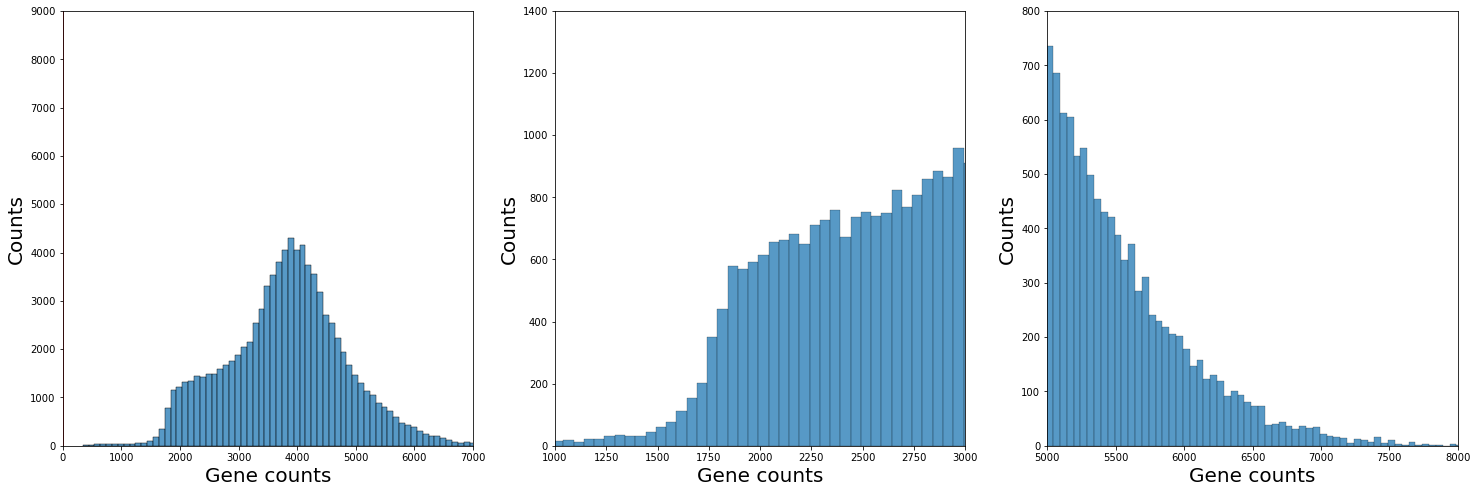

In [7]:
fig,ax = plt.subplots(1,3,figsize=[25,8])

##Genes
i0 = 0; i1 = 0;
sb.histplot(data=adata.obs,x="#Genes",ax=ax[i0],binwidth=100);
ax[i0].axis([0,7000,0,9000])
ax[i0].vlines(MIN_GENES,0,10000,color="r")
#ax[i0].text(MIN_GENES-300,1500,"Lower #Genes cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Gene counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

i0 = 1; i1 = 1;
sb.histplot(data=adata.obs,x="#Genes",ax=ax[i0],binwidth=50);
ax[i0].axis([1000,3000,0,1400])
ax[i0].vlines(MIN_GENES,0,4000,color="r")
#ax[i0].text(MIN_GENES-100,1500,"Lower #Genes cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Gene counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

i0 = 2; i1 = 2;
sb.histplot(data=adata.obs,x="#Genes",ax=ax[i0],binwidth=50);
ax[i0].axis([5000,8000,0,800])
ax[i0].vlines(MAX_GENES,0,5000,color="r")
#ax[i0].text(MAX_GENES+100,100,"Higher #Genes cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Gene counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

fig.savefig("Plots/1_QC_Gene_counts.png",bbox_inches="tight",transparent=True)
fig.show()

## Mitochondrial fraction

The dataset has already a predefined upper bound, which will represent dead or dying cells. According to Pijuan's article, after a extremely convoluted process involving clustering the data in a very sloppy way they concluded that they should also remove all cells with a mitochondrial fraction below 0.005.

I consider this process to be very weird and suspicious and simply chose a lower bound according to the bidomal distribution of the mt fraction. This subset if considered to be due to stripped cells, which exploded and only genes from the nuclei are present mostly. 

Although it is clear that there is a subset of cells that show a extremelly low expression of mitochondrial genes, which will be an indicator of stripped cells, in the original work, this fraction is never removed from the system.

In order to stay as close as possible to the results of the original work, **we will not remove the stipped cells at this point**.

In [8]:
MIN_MT_FRACTION = 0.0065

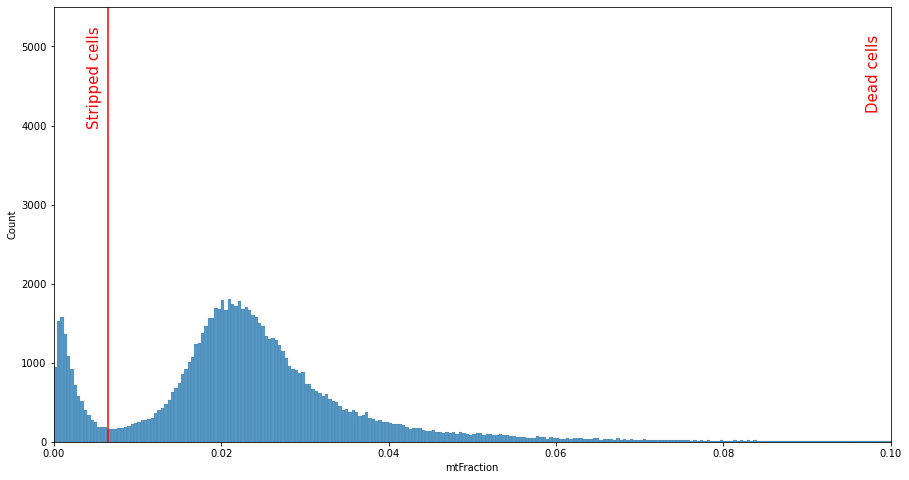

In [9]:
fig,ax = plt.subplots(1,1,figsize=[15,8])

#metFraction
i0 = 3; i1 = 0;
sb.histplot(data=adata.obs,x="mtFraction",ax=ax,binwidth=0.0004);
ax.axis([0,0.10,0,5500])
ax.vlines(MIN_MT_FRACTION,0,6000,color="r")
ax.text(0.004,4000,"Stripped cells",color="red",fontsize=15,rotation="vertical")
ax.vlines(MAX_MT_FRACTION,0,6000,color="r")
ax.text(0.097,4200,"Dead cells",color="red",fontsize=15,rotation="vertical")

fig.savefig("Plots/1_QC_mt_fraction.png",bbox_inches="tight",transparent=True)
fig.show()

## Scatter plot

From the scatter plot it looks like there is a bimodality. This may happen because a certain set of cells have a different gene expression diversity as other cells. We discuss that in a [section below](#Bimodality). 

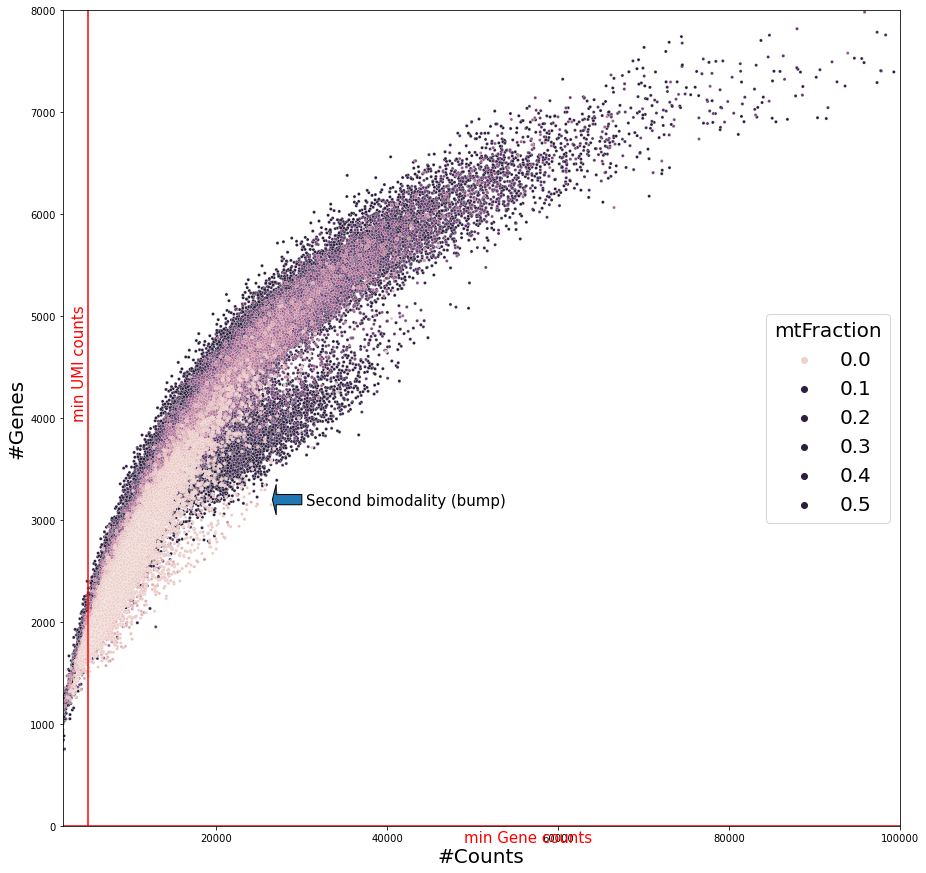

In [10]:
fig,ax = plt.subplots(1,1,figsize=[15,15])

i0 = 0
data = adata.obs.copy()
data.sort_values("mtFraction",inplace=True,ascending=False)
sb.scatterplot(x="#Counts",y="#Genes",hue="mtFraction",data=data,hue_norm=(0,0.02),ax=ax,s=10)
axis = [2000,100000,0,8000]
ax.legend(frameon=True,loc="center right",fontsize=20,title="mtFraction",title_fontsize=20)
ax.axis(axis)
ax.vlines(MAX_COUNTS,axis[2],axis[3])
#ax.text(maxCounts,5000,"min UMI count",rotation="vertical")
ax.vlines(MIN_COUNTS,axis[2],axis[3],color="r")
ax.text(MIN_COUNTS-(axis[1]-axis[0])*0.02,(axis[3]-axis[2])/2,"min UMI counts",color="r",rotation="vertical",fontsize=15)
#ax.hlines(MAX_GENES,axis[0],axis[1],color="r")
#ax.text((axis[1]-axis[0])/2,MAX_GENES+(axis[3]-axis[2])*0.01,"max Gene counts",color="r",rotation="horizontal",fontsize=15)
ax.hlines(MIN_GENES,axis[0],axis[1],color="r")
ax.text((axis[1]-axis[0])/2,MIN_GENES-(axis[3]-axis[2])*0.02,"min Gene counts",color="r",rotation="horizontal",fontsize=15)
ax.set_xlabel("#Counts",fontsize=20)
ax.set_ylabel("#Genes",fontsize=20)
ax.arrow(30000,3200,-3000,0,width=100)
ax.text(30500,3150,"Second bimodality (bump)",fontsize=15)

fig.savefig("Plots/1_QC_UMI_Genes_scatter.png",bbox_inches="tight",transparent=True)
fig.show()

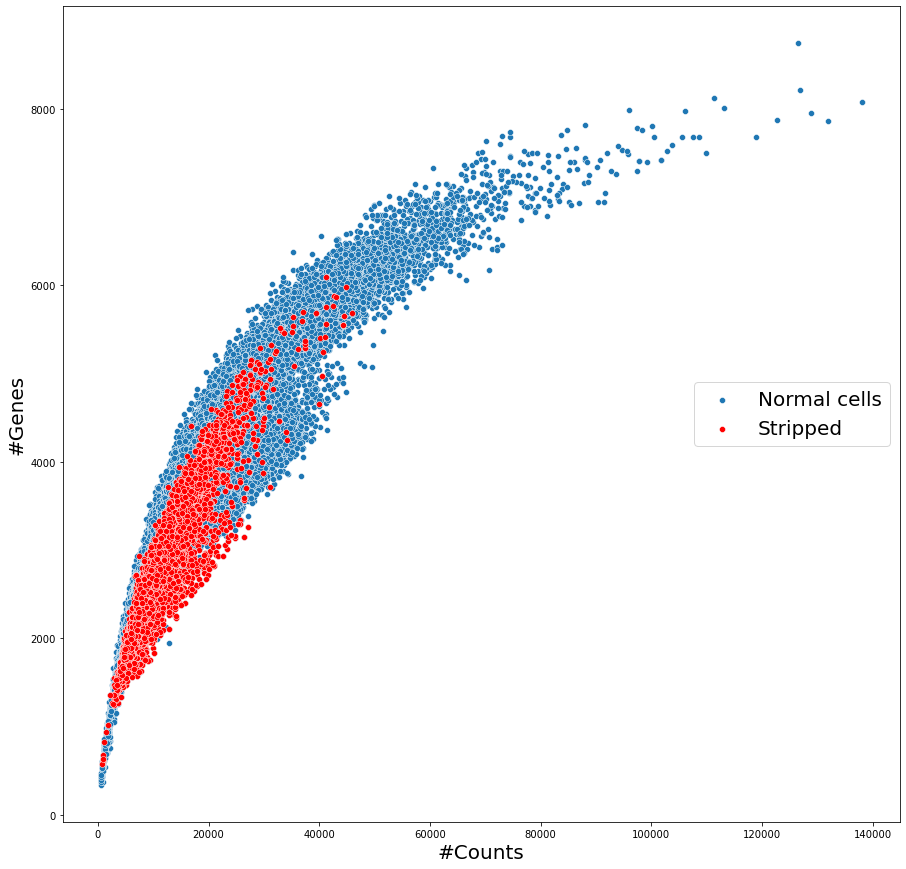

In [11]:
fig,ax = plt.subplots(1,1,figsize=[15,15])

i0 = 1
sb.scatterplot(x="#Counts",y="#Genes",data=adata.obs,ax=ax)
sb.scatterplot(x="#Counts",y="#Genes",color="r",data=adata.obs[adata.obs["mtFraction"]<MIN_MT_FRACTION],ax=ax)
ax.legend(["Normal cells","Stripped"],frameon=True,loc="center right",fontsize=20)
ax.set_xlabel("#Counts",fontsize=20)
ax.set_ylabel("#Genes",fontsize=20)

fig.savefig("Plots/1_QC_UMI_Genes_stripped.png",bbox_inches="tight",transparent=True)
fig.show()

### Scatter plot bimodality 

As in Pijuan, we look at the gene Hbb-bh1, which is an indicator of blod cell lines. As it can be seen, the second bump in the scatter plot comes from cells expressing the blod cell line indicator and start appearing from the later stages of the development. 

Blod cells show a lower diversity of genes, which is represented in the plots by the second modality at a lower gene expression. This confirms that we are not runing into technical artifacts with the datadata.

IndexError: index 5 is out of bounds for axis 0 with size 5

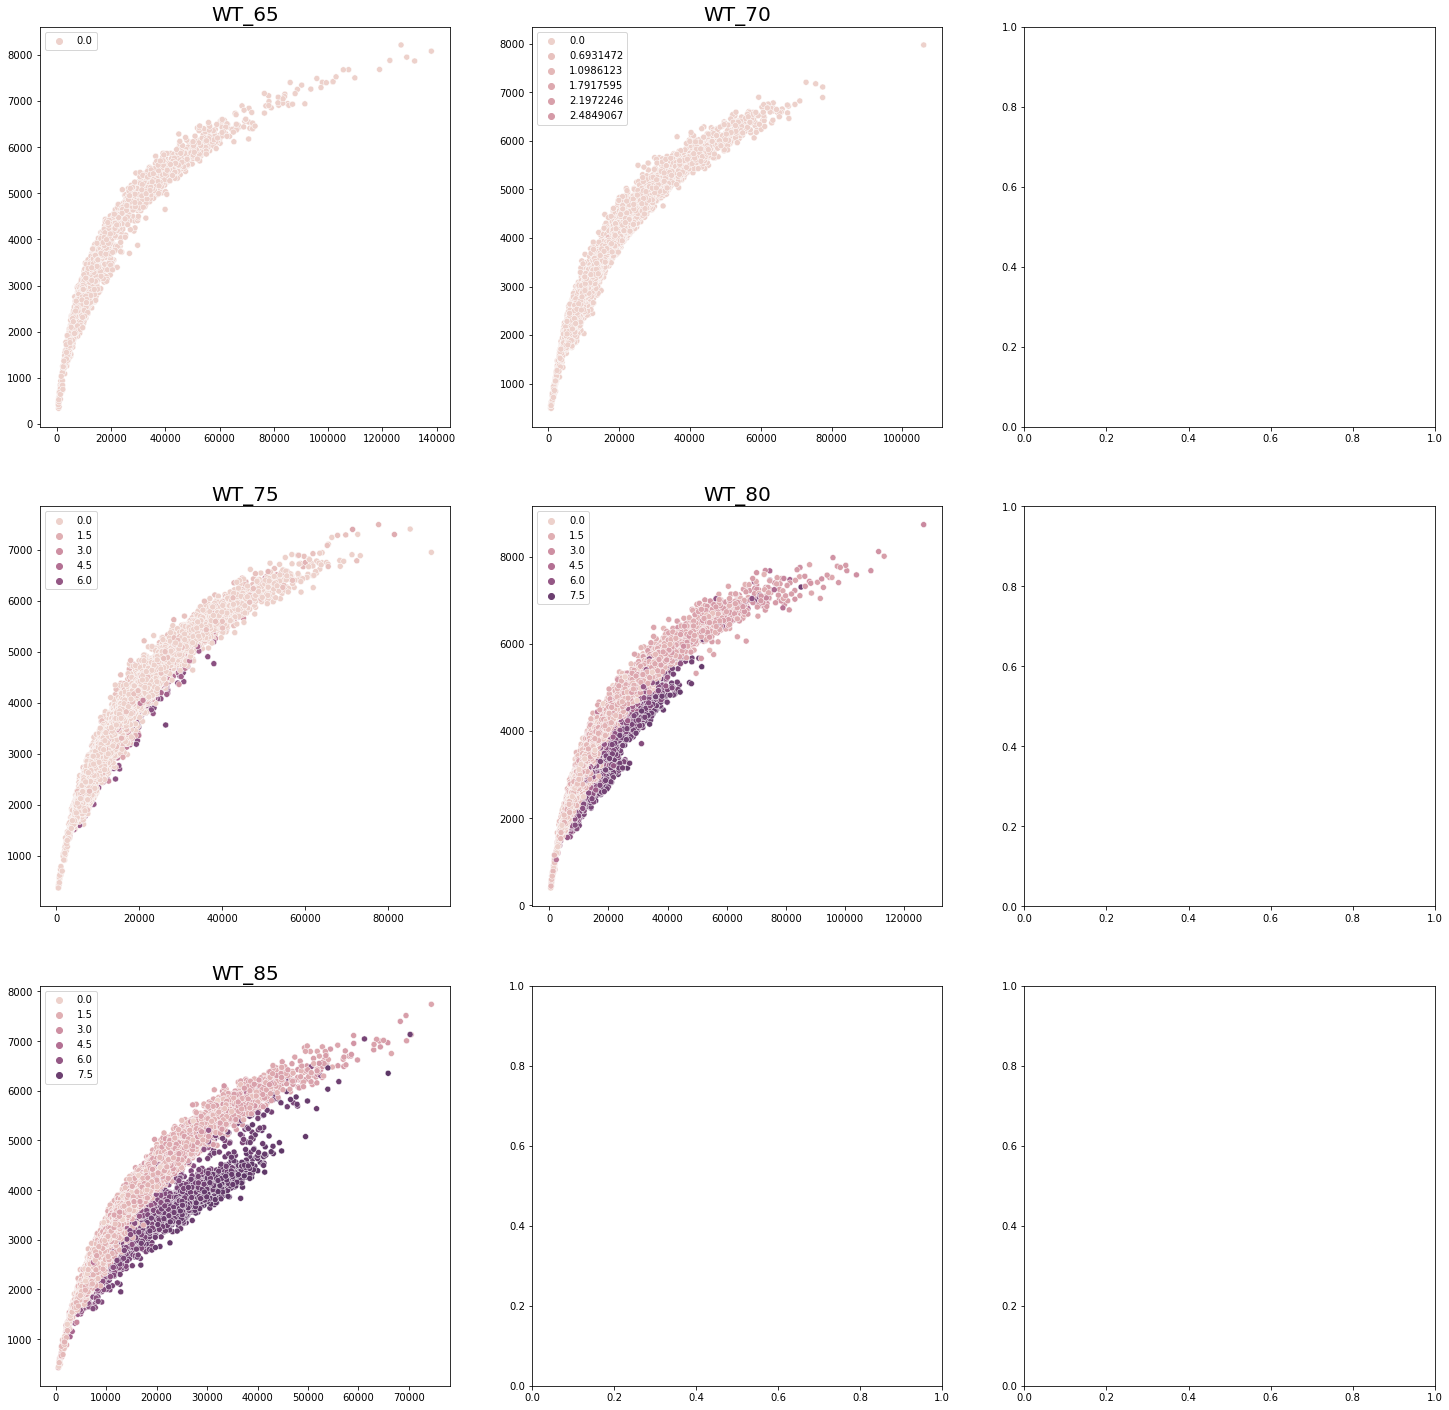

In [12]:
samp = np.sort(adata.obs["Stage"].unique())

fig,ax=plt.subplots(3,3,figsize=[25,25])
m = np.meshgrid(range(3),range(3))
hue = np.log(np.array(adata[:,adata.var["Gene"]=="Hbb-bh1"].X.todense()).reshape(-1)+1)
for i,j in zip(m[0].reshape(9),m[1].reshape(9)):
    k = 2*i+j
    l = adata.obs["Stage"]==samp[k]
    sb.scatterplot(x="#Counts",y="#Genes",hue=hue[l],hue_norm=(0,10),data=adata.obs[l],ax=ax[i,j])
    ax[i,j].set_xlabel("")
    ax[i,j].set_ylabel("")
    ax[i,j].set_title(str(samp[k]),fontsize=20)#,loc='lower right')
    
fig.text(0.5, 0.08, '#Genes', ha='center', fontsize=40)
fig.text(0.08, 0.5, '#Counts', va='center', rotation='vertical', fontsize=40)

fig.savefig("Plots/1_QC_Second_bimodality.png",bbox_inches="tight",transparent=True)
fig.show()

## Plots by samples

We do a quality check over the different samples of the dataset.

From their preprocessing, they already eliminated one sample (11) because showed an anomalous number of cells. But we keep it for sake of consistency with the preprocessing performed in the original paper.

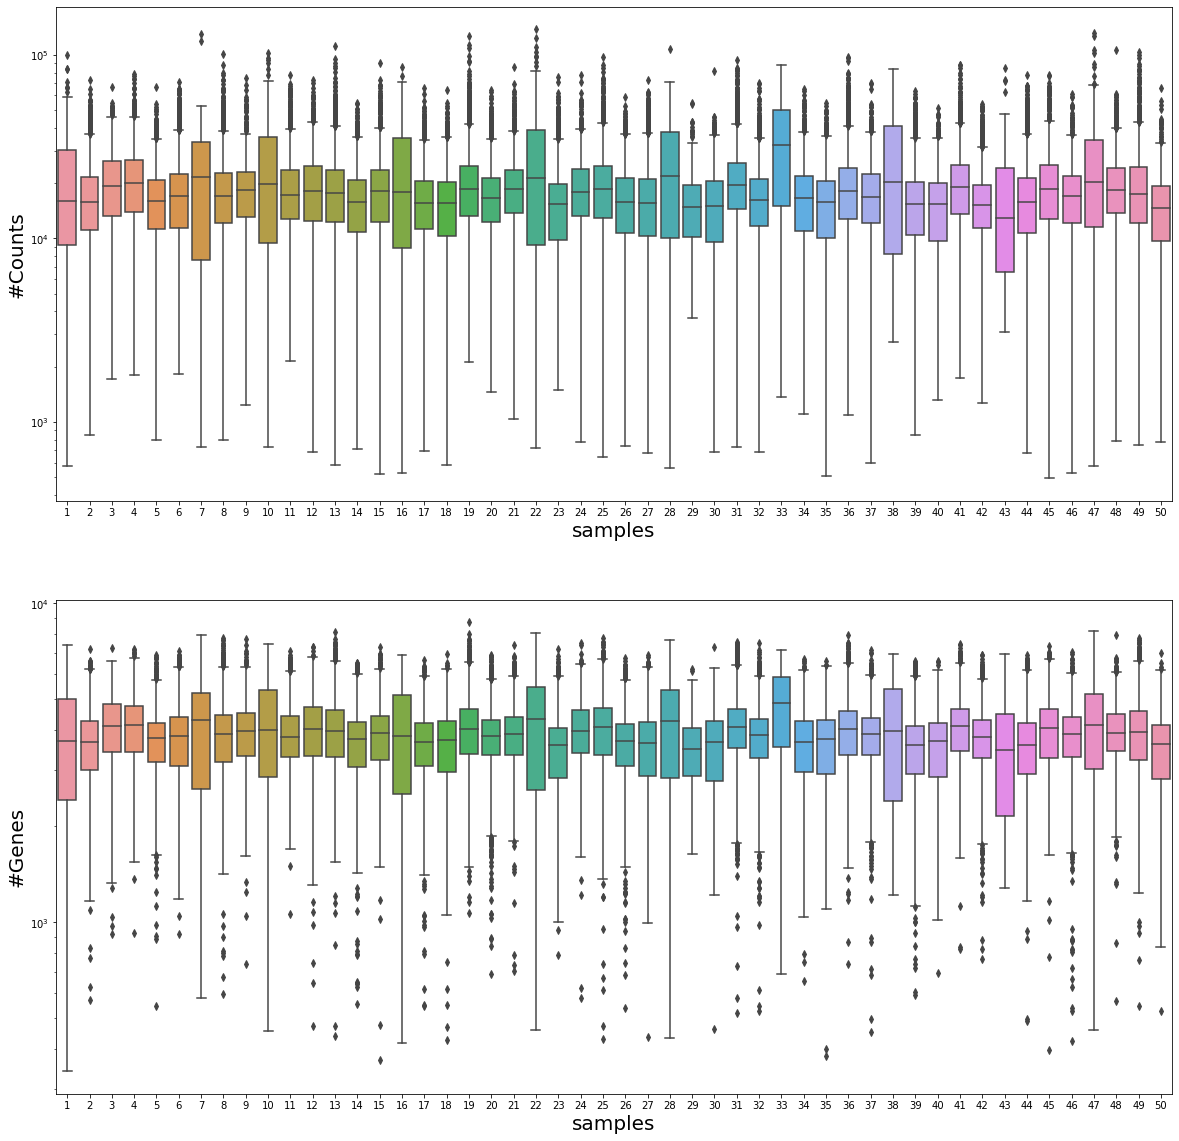

In [13]:
fig,ax = plt.subplots(2,1,figsize=[20,20])

sb.boxplot(y="#Counts",x="Sample",data=adata.obs,ax=ax[0])
ax[0].set_yscale("log")
ax[0].set_xlabel("samples",fontsize=20)
ax[0].set_ylabel("#Counts",fontsize=20)

sb.boxplot(y="#Genes",x="Sample",data=adata.obs,ax=ax[1])
ax[1].set_yscale("log")
ax[1].set_xlabel("samples",fontsize=20)
ax[1].set_ylabel("#Genes",fontsize=20)

fig.savefig("Plots/1_QC_UMI_Genes_sample.png",bbox_inches="tight",transparent=True)
fig.show()

## Plots by stages

When plotting against the stages, there does not seem to be bias on the expression and count levels.

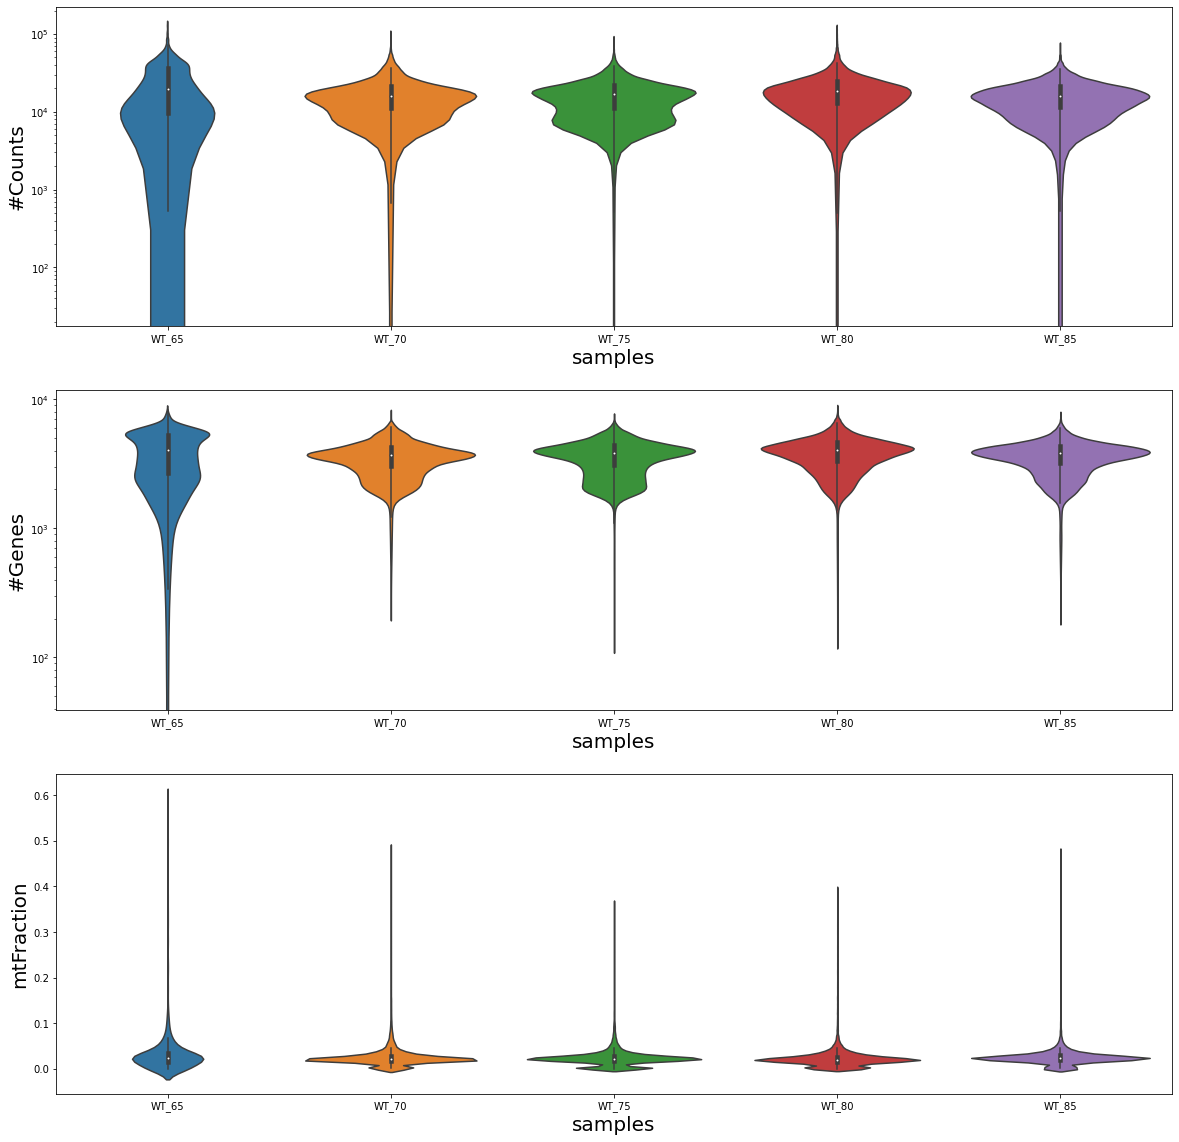

In [14]:
fig,ax = plt.subplots(3,1,figsize=[20,20])

sb.violinplot(y="#Counts",x="Stage",data=adata.obs,ax=ax[0])
ax[0].set_yscale("log")
ax[0].set_xlabel("samples",fontsize=20)
ax[0].set_ylabel("#Counts",fontsize=20)

sb.violinplot(y="#Genes",x="Stage",data=adata.obs,ax=ax[1])
ax[1].set_yscale("log")
ax[1].set_xlabel("samples",fontsize=20)
ax[1].set_ylabel("#Genes",fontsize=20)

sb.violinplot(y="mtFraction",x="Stage",data=adata.obs,ax=ax[2])
ax[2].set_xlabel("samples",fontsize=20)
ax[2].set_ylabel("mtFraction",fontsize=20)

fig.savefig("Plots/1_QC_UMI_Genes_stage.png",bbox_inches="tight",transparent=True)
fig.show()

# Doublets

Before this control, we account for doublet cells by running:

    1. Scrublet algorithm

## Compute doublet scores

### Scrublet

Scrublet algorithm for the detectiuon of doublets. We perform this algorithm with the following characteristics:

- Each sample is analized independently as doublets are produced within each mouse sample with their own batch effects and disgregation problems.
- The doublet score is computed generating doublets and considering the neighbors in a reduced space constructed as:
    - Highly Variable Genes (HVGs) as selected automatically by "seurat" algorithm in `scanpy.pp.highly_varying_genes`.
    - Removed HVGs related with cell cycle and sex.
    - Retained 50 Principal Components (PCs) `scanpy.pp.pca`.
    - KNN matrix generated with the 50 PCs and "correlation" metric as implemented in `scanpy.pp.neighbors`.

In [15]:
scrublet_pipeline(adata,
                batch_key="Sample",
                normalize=True,
                target_sum=adata.obs["#Counts"].mean(),
                log_normalize=True,
                feature_reduction_flavor="seurat",
                n_retained_features=None,
                exclude_genes=SKIP_GENES,
                key_exclude_list="Gene",
                n_prin_components = 50,
                knn_dist_metric="correlation",
                key_added="Scrublet_score",
                doublet_statistics_file="Results/Scrublet_doublet_scores",
                verbose=True)

Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.19
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 30.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.3%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.20
Detected doublet rate = 2.6%
Estimated detectable doublet fraction = 22.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 11.7%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.22
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 30.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.29
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 31.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.18
Detected doublet rate = 0.9%
Estimated detectable doublet fraction = 37.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.4%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.16
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 21.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.1%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.11
Detected doublet rate = 8.2%
Estimated detectable doublet fraction = 10.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 80.0%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.18
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 29.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.4%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.06
Detected doublet rate = 50.0%
Estimated detectable doublet fraction = 58.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 85.7%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.07
Detected doublet rate = 47.1%
Estimated detectable doublet fraction = 31.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 150.0%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 15.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.6%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.39
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 18.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.1%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 13.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.6%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.42
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 12.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.5%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 15.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.0%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 19.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.9%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.20
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 16.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 10.8%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 16.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.6%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.36
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 23.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.2%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.34
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 9.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 6.3%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 5.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.5%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 6.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.7%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 12.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.6%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 6.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.1%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.39
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 8.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.8%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 7.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.7%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.26
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 32.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.4%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 7.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.7%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.37
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 17.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.9%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.32
Detected doublet rate = 0.9%
Estimated detectable doublet fraction = 31.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.0%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 3.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.7%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.39
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 9.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.6%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.40
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 11.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.1%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 7.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 7.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.5%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 6.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.9%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 7.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.0%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.34
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 11.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.7%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 5.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.8%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 5.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.5%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.33
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 26.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.6%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 15.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.6%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 10.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.8%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.33
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 17.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.5%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 11.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.6%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 12.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.3%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 12.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.9%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 12.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.6%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 3.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 6.4%


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.33
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 10.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.8%


We choose the doublet score to impute as cells base on a unique threshold for all doublet bimodality diagrams. Up to this point of the analysis we do not remove any cells from the dataset.

Text(0.5, 0, 'Sample')

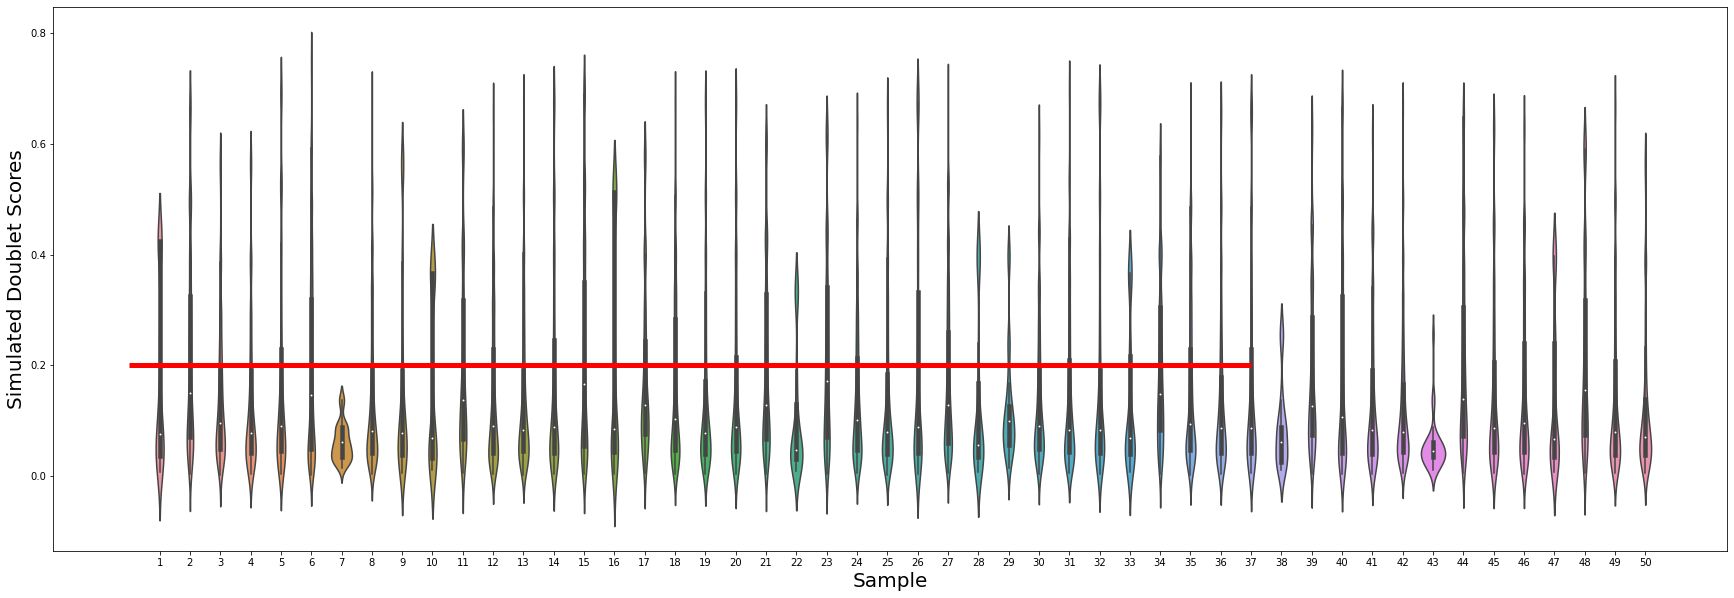

In [16]:
data = pd.read_csv("Results/Scrublet_doublet_scores")

fig, ax = plt.subplots(1,1,figsize=[30,10])
sns.violinplot(data=data,x="Sample",y="doublet_score_sim")
ax.hlines(DOUBLET_SCORE_MAX_THRESHOLD,-1,36,linewidth=5,zorder=10,color="red")
ax.set_ylabel("Simulated Doublet Scores",fontsize=20)
ax.set_xlabel("Sample",fontsize=20)

# Dimensionality reduction

In this stage, we make a dimensionality reduction of the RNA space that encodes the information in a relevant space. **This analysis is performed for each temporal Stage of development independently as different times during development may be captured more effectively with different effective spaces.**

For obtaining each reduced space we follow the following pipeline:

1. Normalize the total count to the mean number of counts among all cells of the dataset.
2. Log normalize the counts. 
3. Select Highly Varying Genes using Seurat algorithm as implemented by `scanpy.pp.highly_varying_genes`. We remove from the highly varying genes those genes related to growth and sex.
4. Perform PCA analysis over the HVGs divemnsions and retain the 50 most variable PCs as our reduced space. We use the implementation of `scanpy.pp.pca`.

In [17]:
# Normalize to the mean total
scp.pp.normalize_total(adata,target_sum=adata.obs.loc[:,"#Counts"].mean())
# Lognormalize
scp.pp.log1p(adata)

In [18]:
USE_HVGs = True

In [19]:
dimensionality_reduction_pipeline(adata)

2022-04-27 18:24:49.195837: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2022-04-27 18:24:49.195873: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### UMAPs by stages

For visualization of the data, we further perform the following steps:

5. KNN matrix generated with the 50 PCs and "correlation" metric as implemented in `scanpy.pp.neighbors`.
6. UMAP in 2D representations as implemented in `scanpy.tl.umap`.

Visualization of the reduced space by stages shows batch effects distortions that should be corrected.

In [20]:
neighbors_batches(adata,use_rep="X_pca_Stage",metric=METRIC)

In [21]:
umap_batches(adata,neighbors_key="Neighbors_Stage")

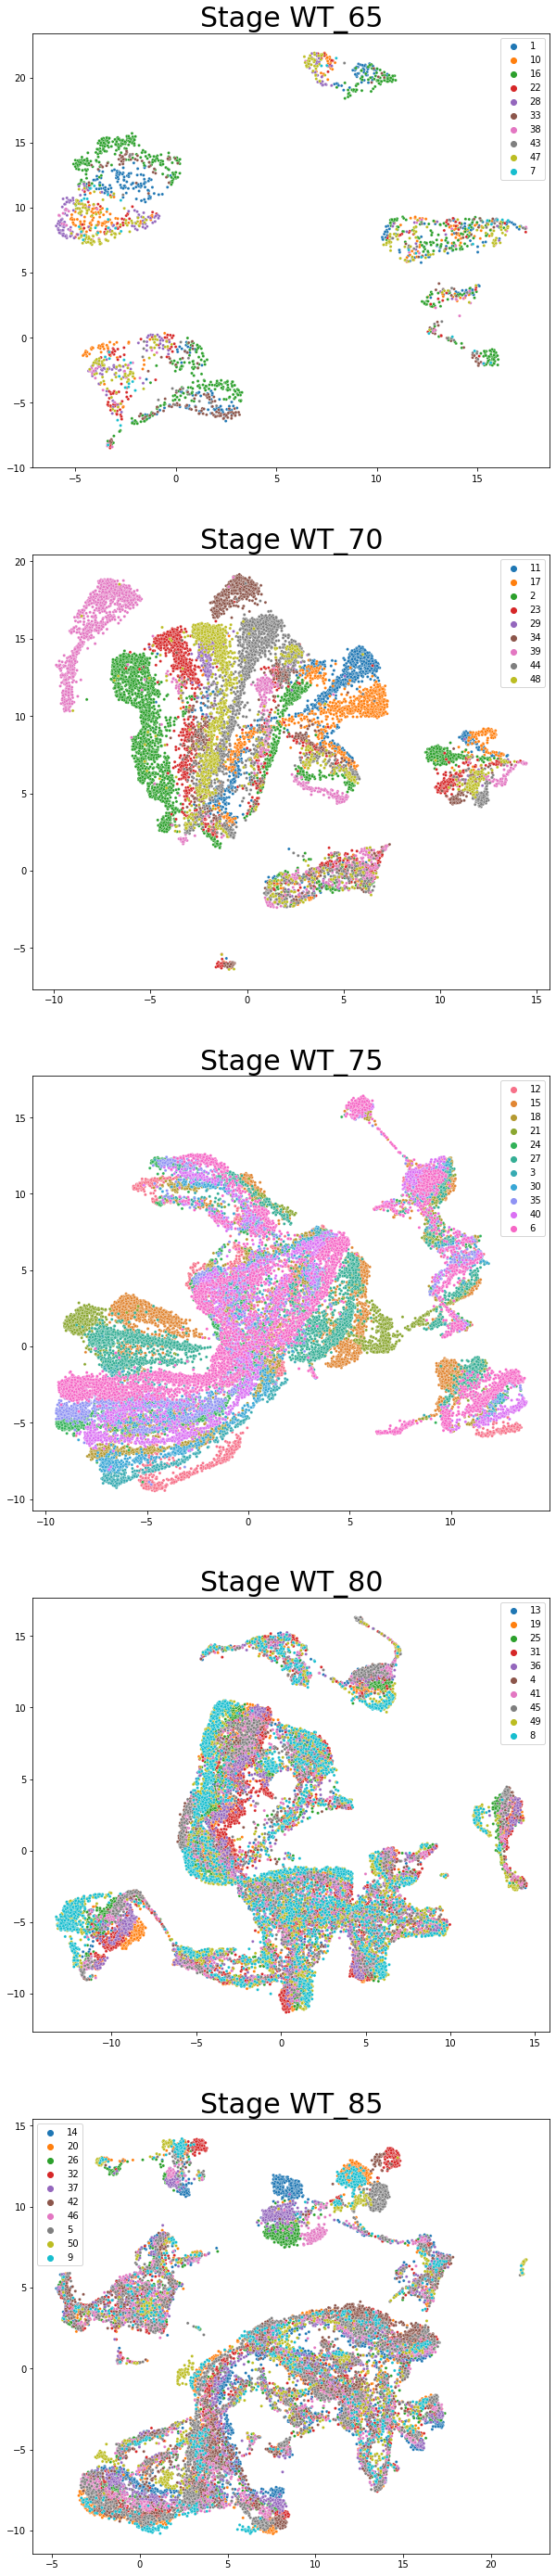

In [22]:
fig,ax= plt.subplots(len(adata.obs["Stage"].unique()),figsize=[10,10*len(adata.obs["Stage"].unique())])

for i,stage in enumerate(adata.obs["Stage"].unique()):
    
    l = adata.obs.loc[:,"Stage"]==stage
    
    order = np.argsort(adata.obs.loc[l,"Sample"].values.astype(str))
    hue = np.sort(adata.obs.loc[l,"Sample"].values.astype(str))
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0][order],adata.obsm["X_umap_Stage"][l,1][order],hue=hue,s=10,ax=ax[i])
    ax[i].set_title("Stage "+stage,fontsize=30)

## Batch correction

We correct the batch effects with the follwing algorithms:

1. Harmony provided in `scanpy.external.pp.harmony_integrate`.

The PCS corrected show a proper correction of the batch effects between samples for all stages.

### Harmony

In [23]:
harmony_integrate_batches(adata,verbose=False)

In [24]:
neighbors_batches(adata,add_key="Neighbors_Harmony_Stage",use_rep="X_pca_Harmony_Stage",metric=METRIC)

In [25]:
umap_batches(adata,neighbors_key="Neighbors_Harmony_Stage")

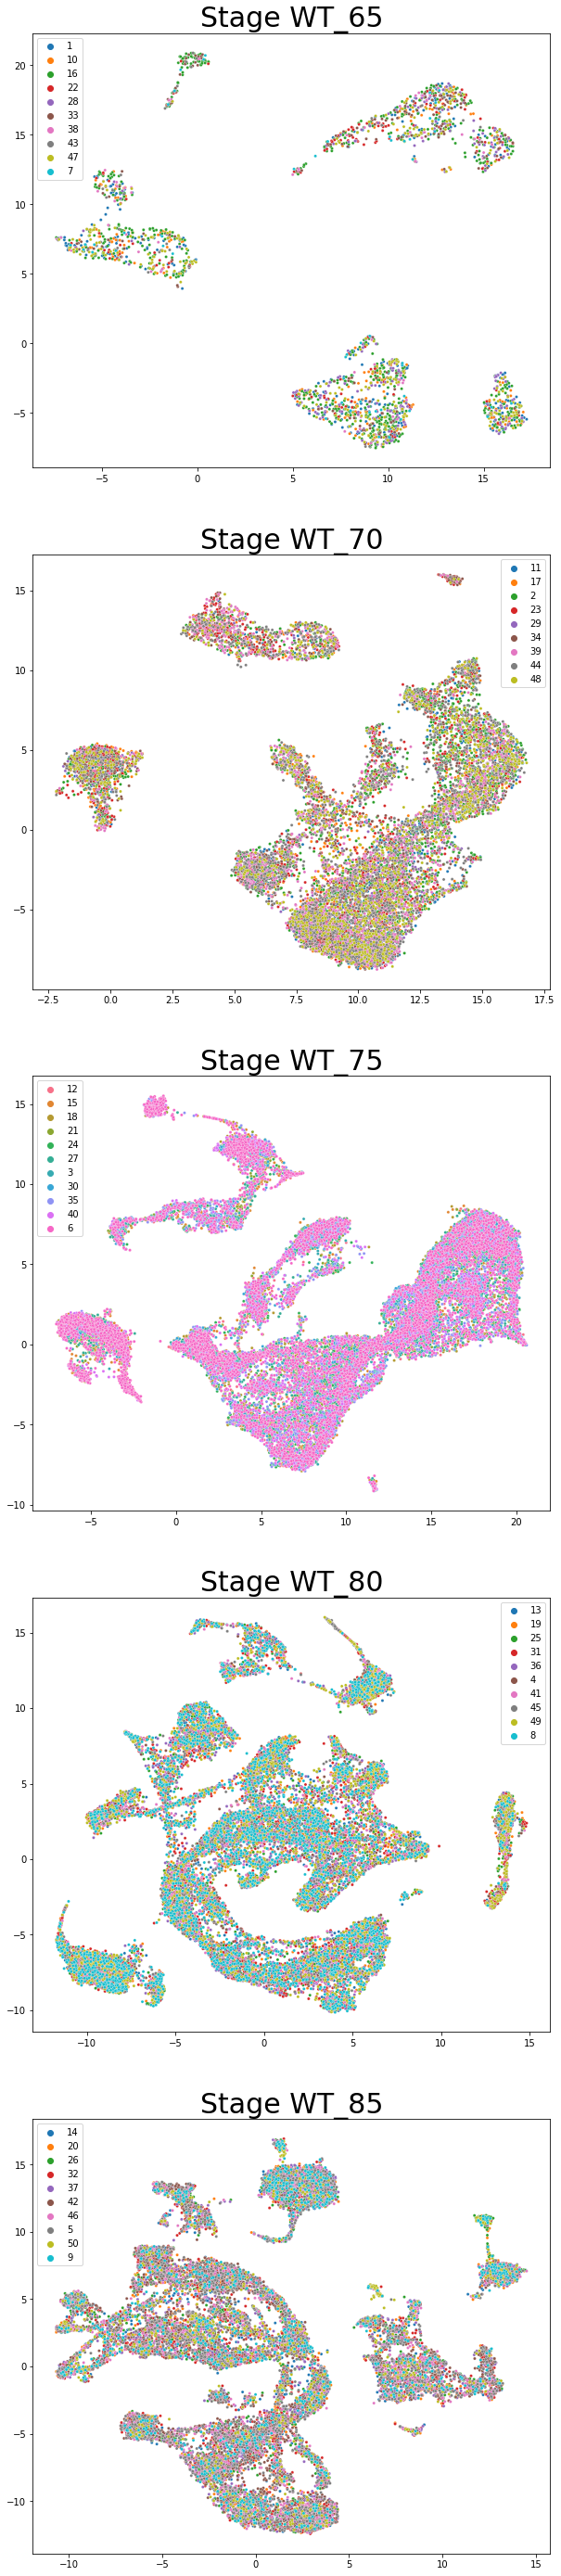

In [26]:
fig,ax= plt.subplots(len(adata.obs["Stage"].unique()),figsize=[10,10*len(adata.obs["Stage"].unique())])

for i,stage in enumerate(adata.obs["Stage"].unique()):
    
    l = adata.obs.loc[:,"Stage"]==stage
    
    order = np.argsort(adata.obs.loc[l,"Sample"].values.astype(str))
    hue = np.sort(adata.obs.loc[l,"Sample"].values.astype(str))
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0][order],adata.obsm["X_umap_Stage"][l,1][order],hue=hue,s=10,ax=ax[i])
    ax[i].set_title("Stage "+stage,fontsize=30)

# Imputed cells

After correcting for batch effects, we visualize the location of stripped and doublets cells that where imputed during the Quality Control. Most of the imputed cells show grouped in clusters. This is consistent with our expectation of stripped and doublet cells to group as "cell types" of artificial nature. 

In [27]:
adata.obs.loc[:,"Imputed"] = (adata.obs.loc[:,"mtFraction"] < MIN_MT_FRACTION) + (adata.obs.loc[:,"Scrublet_score"] > DOUBLET_SCORE_MAX_THRESHOLD)

### UMAP imputed cells

For comparison, we visualize the cells that we impute in our analysis and those from the original paper from Marioni finding a great discrepancy in the removal of cells. Putting a more restrictive threshold to our analysis recover a closer cleaning of the original analysis showing that our filtering is in general more permissive.

Text(0.5, 1.0, 'Our analysis (doublet threshold .1)')

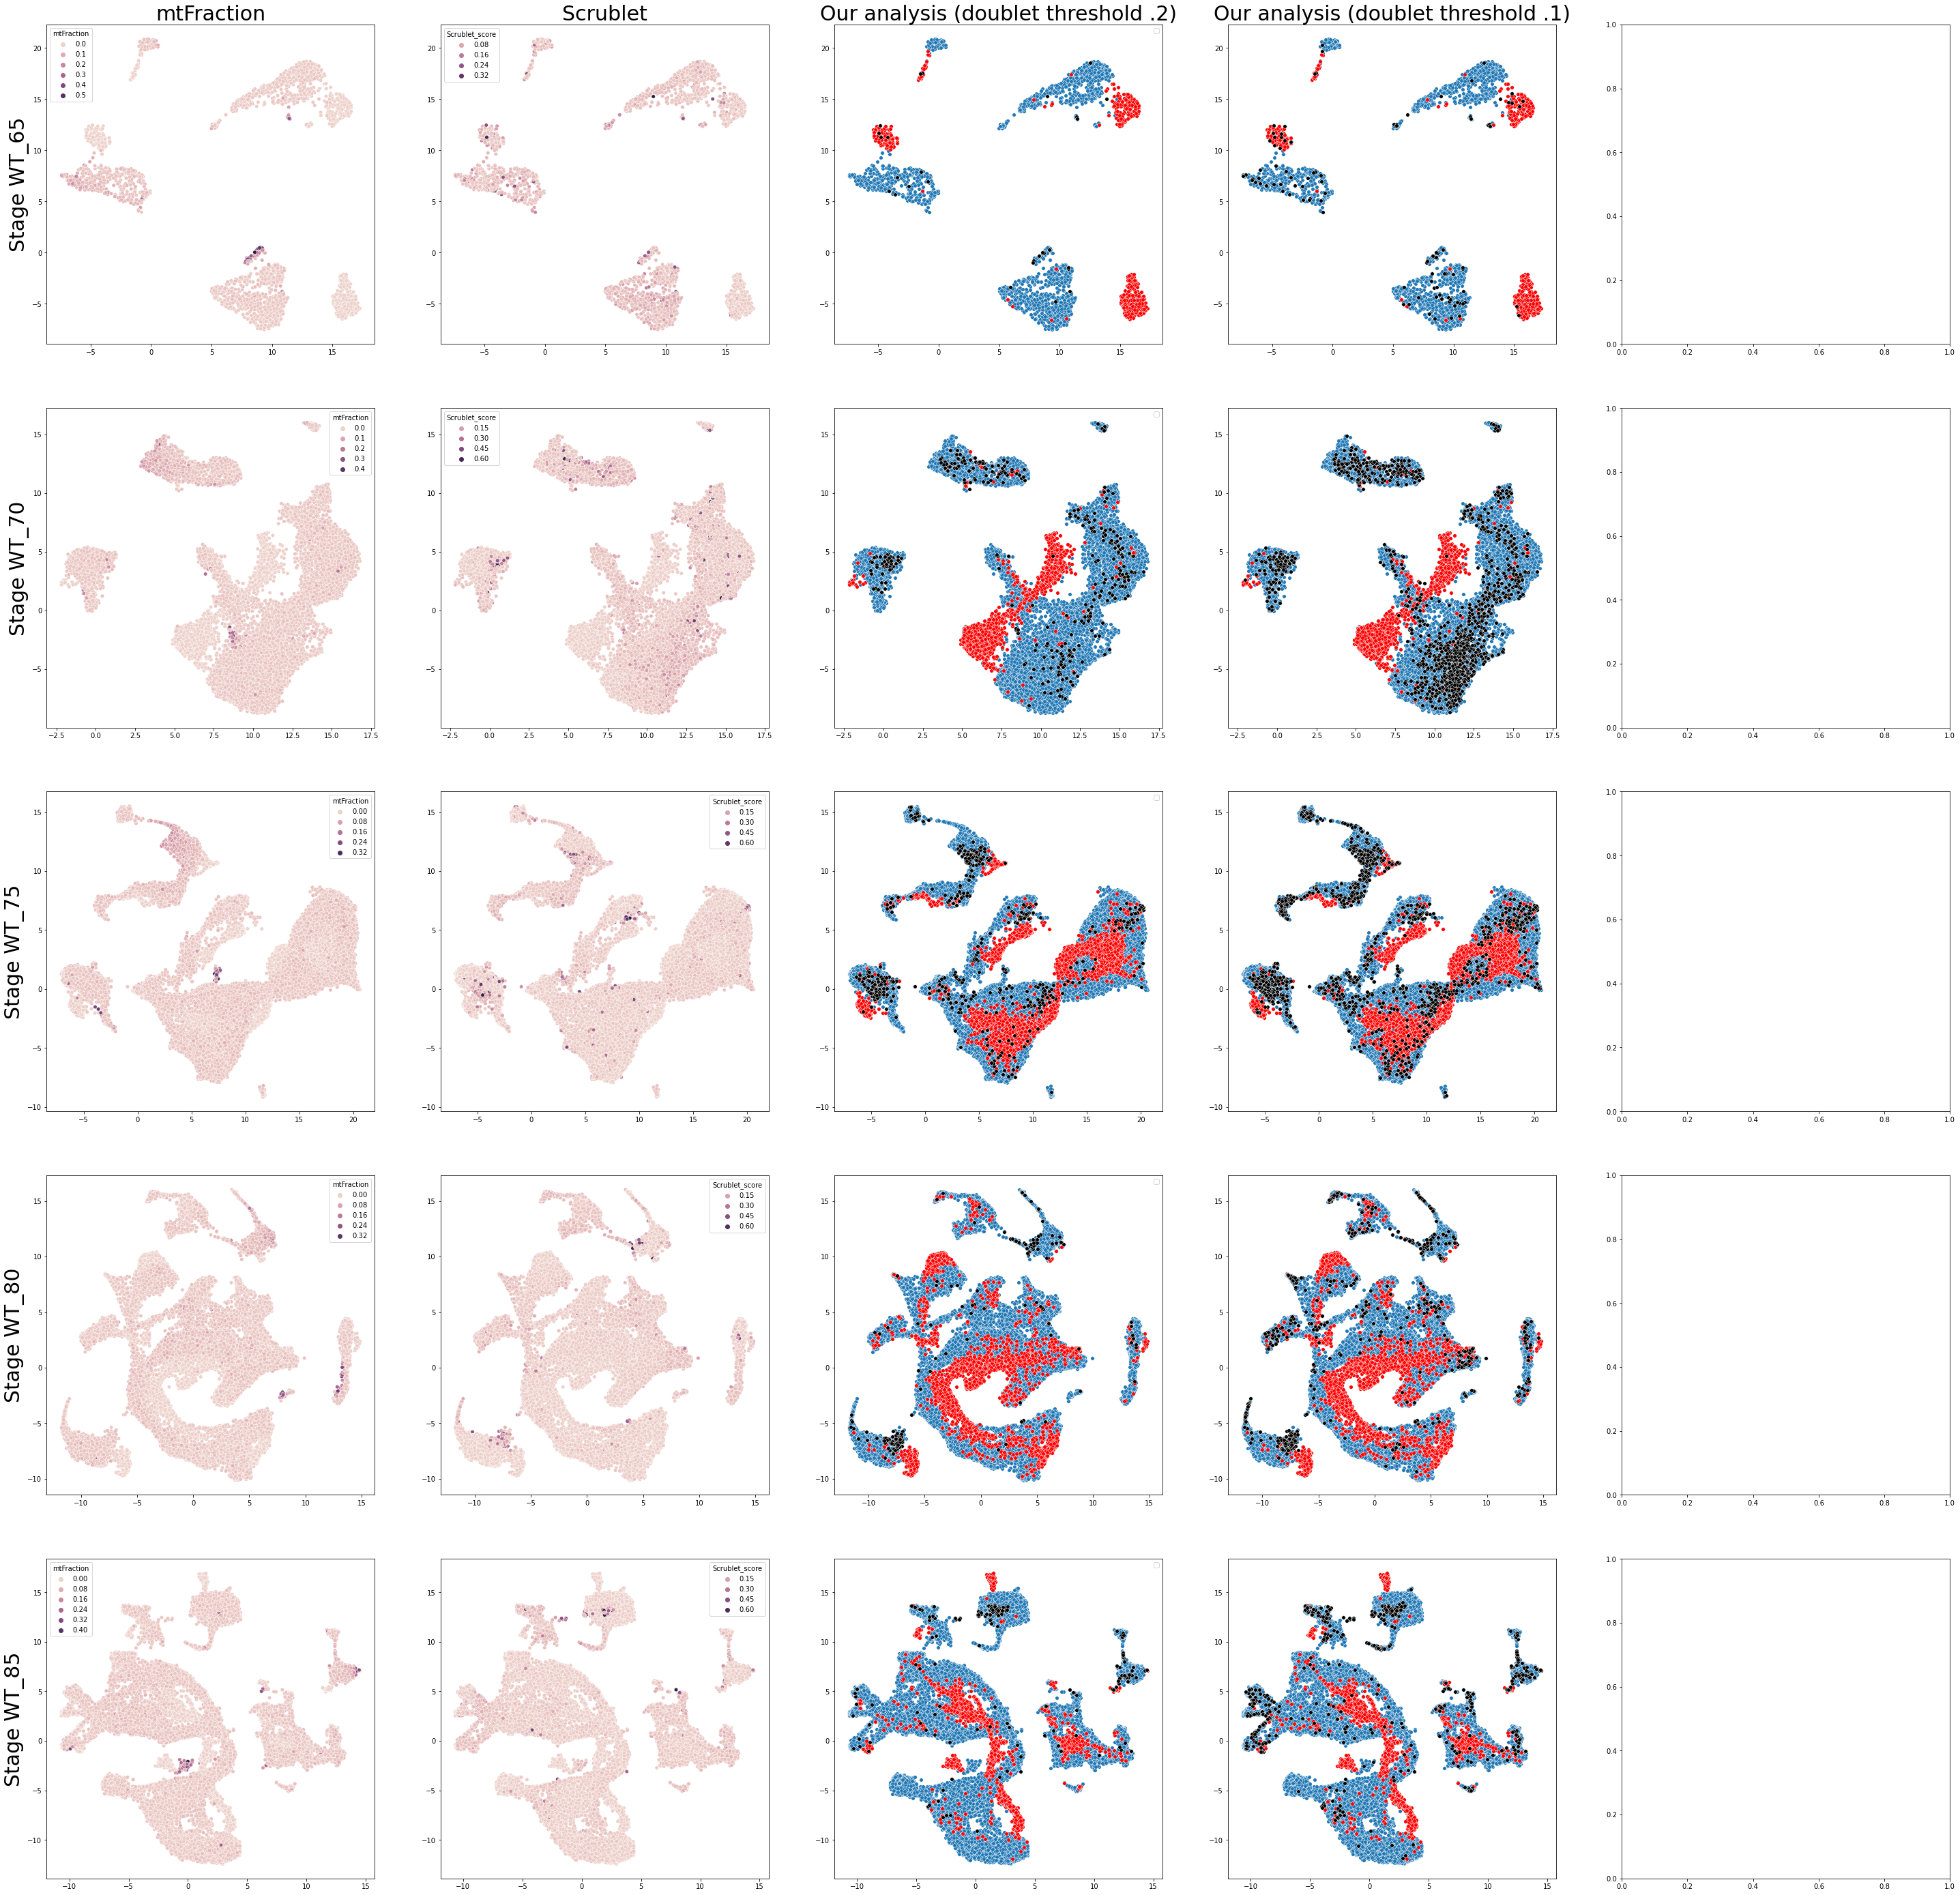

In [28]:
fig,ax= plt.subplots(len(adata.obs["Stage"].unique()),5,figsize=[50,10*len(adata.obs["Stage"].unique())])

data = pd.read_csv("/lustre/projects/Stembryo_Seq/data/sc_sumit/pijuan_sala_data/atlas/meta.tab",sep="\t",skiprows=0)

for i,stage in enumerate(adata.obs["Stage"].unique()):
        
    ax[i,2].legend(["Retained","Stripped","Doublet"])
    ax[i,0].set_ylabel("Stage "+stage,fontsize=30)
    
    l = adata.obs.loc[:,"Stage"]==stage    

    hue = adata.obs.loc[l,"mtFraction"]
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0],adata.obsm["X_umap_Stage"][l,1],hue=hue,s=30,ax=ax[i,0])

    hue = adata.obs.loc[l,"Scrublet_score"]
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0],adata.obsm["X_umap_Stage"][l,1],hue=hue,s=30,ax=ax[i,1])
    
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0],adata.obsm["X_umap_Stage"][l,1],s=30,ax=ax[i,2])
    stripped = adata.obs.loc[l,"mtFraction"] < MIN_MT_FRACTION
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0][stripped],adata.obsm["X_umap_Stage"][l,1][stripped],color="red",s=30,ax=ax[i,2])
    stripped = adata.obs.loc[l,"Scrublet_score"] > DOUBLET_SCORE_MAX_THRESHOLD
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0][stripped],adata.obsm["X_umap_Stage"][l,1][stripped],color="black",s=30,ax=ax[i,2])

    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0],adata.obsm["X_umap_Stage"][l,1],s=30,ax=ax[i,3])
    stripped = adata.obs.loc[l,"mtFraction"] < MIN_MT_FRACTION
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0][stripped],adata.obsm["X_umap_Stage"][l,1][stripped],color="red",s=30,ax=ax[i,3])
    stripped = adata.obs.loc[l,"Scrublet_score"] > .1#DOUBLET_SCORE_MAX_THRESHOLD
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0][stripped],adata.obsm["X_umap_Stage"][l,1][stripped],color="black",s=30,ax=ax[i,3])
    
#    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0],adata.obsm["X_umap_Stage"][l,1],s=30,ax=ax[i,4])
#    stripped = data.loc[:,"stripped"].values[l]
#    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0][stripped],adata.obsm["X_umap_Stage"][l,1][stripped],color="red",s=30,ax=ax[i,4])
#    stripped = data.loc[:,"doublet"].values[l]
#    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0][stripped],adata.obsm["X_umap_Stage"][l,1][stripped],color="black",s=30,ax=ax[i,4])

ax[0,0].set_title("mtFraction",fontsize=30)
ax[0,1].set_title("Scrublet",fontsize=30)
ax[0,2].set_title("Our analysis (doublet threshold .2)",fontsize=30)
ax[0,3].set_title("Our analysis (doublet threshold .1)",fontsize=30)
#ax[0,4].set_title("Pijuan-Sala",fontsize=30)

### Compare cells imputed by Pijuan-Sala and our analysis

This can't be done until we preprocess the fastq files and subsequently compare the raw data vs the post-QC r-object from Helene.

## Remove imputed cells and recompute dimensionality reduction procedure

Having inspected the reasoable outcome of the imputed cells, we proceed to remove those and recompute the reduced space of the cleaned dataset from steps 1-6 described above and save the data.

In [29]:
# Save first full dataset
adata.write("raw.h5ad");

... storing 'Stage' as categorical


In [30]:
# Eliminate imputed cells
adata = adata[adata.obs["Imputed"] == False]
adata.obs.reset_index(inplace=True)

In [31]:
dimensionality_reduction_pipeline(adata)

In [32]:
harmony_integrate_batches(adata,verbose=False)

In [33]:
neighbors_batches(adata,use_rep="X_pca_Harmony_Stage",metric=METRIC)

In [34]:
umap_batches(adata,neighbors_key="Neighbors_Stage")

### UMAPs by stages

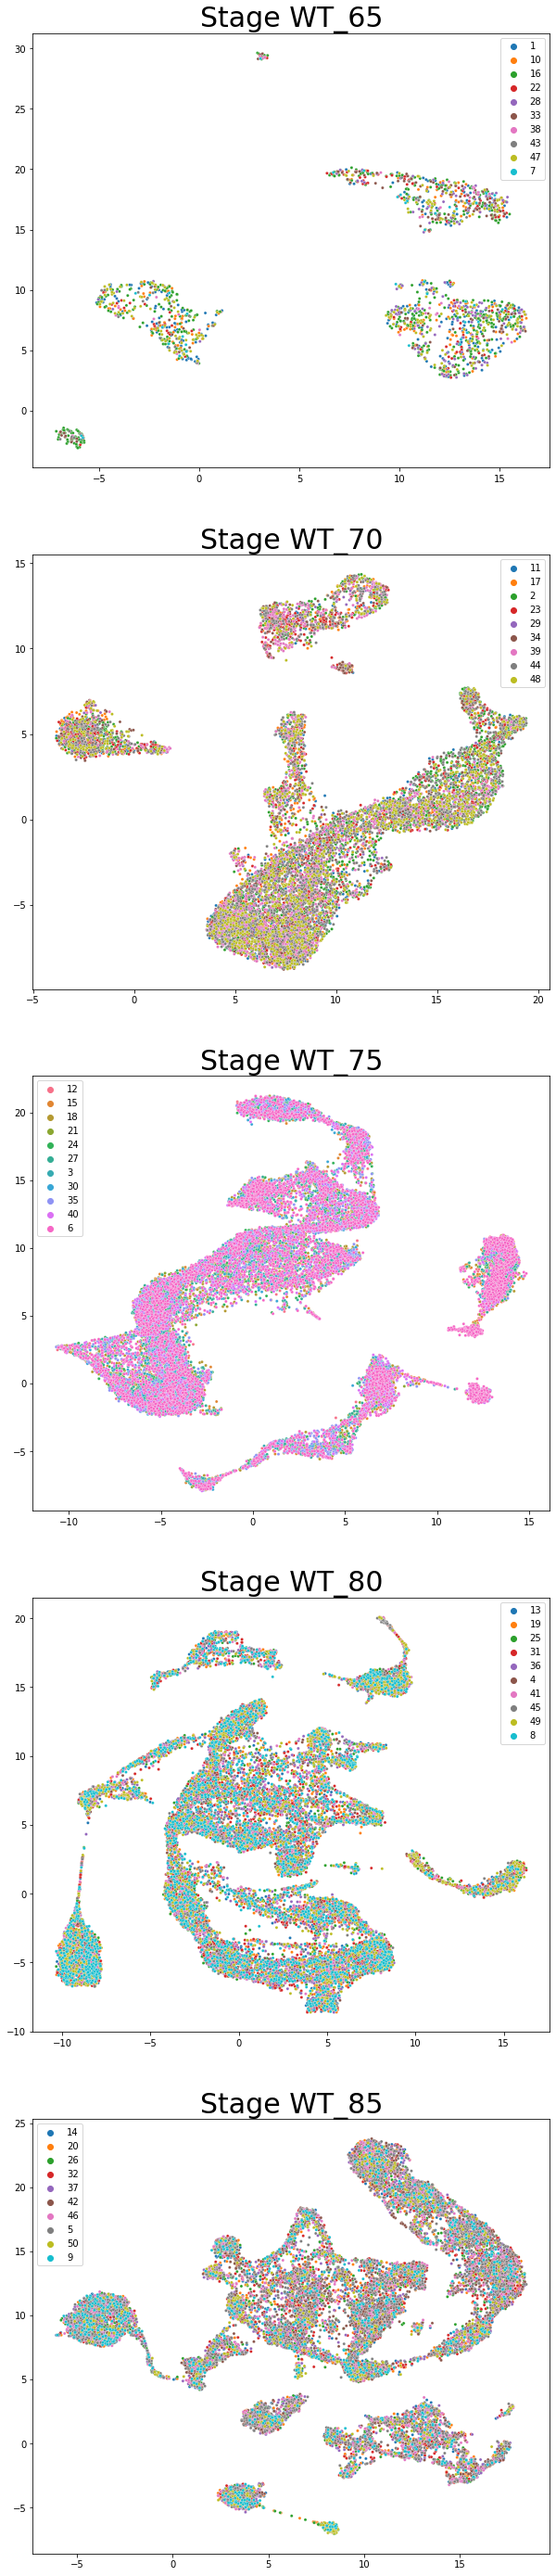

In [35]:
fig,ax= plt.subplots(len(adata.obs["Stage"].unique()),figsize=[10,10*len(adata.obs["Stage"].unique())])

for i,stage in enumerate(adata.obs["Stage"].unique()):
    
    l = adata.obs.loc[:,"Stage"]==stage
    
    order = np.argsort(adata.obs.loc[l,"Sample"].values.astype(str))
    hue = np.sort(adata.obs.loc[l,"Sample"].values.astype(str))
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0][order],adata.obsm["X_umap_Stage"][l,1][order],hue=hue,s=10,ax=ax[i])
    ax[i].set_title("Stage "+stage,fontsize=30)

# Save data

In [36]:
adata.write("qc_m.h5ad");

In [37]:
adata.obs.to_csv("Obs_m.csv",index=False)
adata.var.to_csv("Var_m.csv",index=False)

In [38]:
adata

AnnData object with n_obs × n_vars = 76484 × 22618
    obs: 'index', 'BC', 'Stage', 'Cluster', 'Sample', '#Counts', '#Genes', 'mtFraction', 'Scrublet_score', 'Imputed'
    var: 'ENS', 'Gene', '#Cells'
    uns: 'log1p', 'Neighbors_Stage', 'Neighbors_Harmony_Stage'
    obsm: 'Raw', 'X_pca_Stage', 'X_umap_Stage', 'X_pca_Harmony_Stage'

In [39]:
del adata.obsm
adata.write("/lustre/projects/Stembryo_Seq/meissner_qc_robj_2.h5ad");